In [1]:
import tensorflow as tf
import numpy as np
import collections
import gym
import matplotlib.pyplot as plt
import random

In [2]:
ENV = "CartPole-v0"

In [3]:
MEMORY_SIZE = 1000
BATCH_SIZE = 32

PERIOD_PRMTS = 100
PERIOD_EPSILON = 800

EPISODE = 10000
MAX_STEP = 150

In [4]:
class AgentModel():
    def __init__(self, env , sess , dueling = True , out_graph = False , out_dqn = True):
        self.epsilon = 0.8
        self.gamma = 0.5
        self.action_dim = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.l1_units = 20
        self.learning_rate = 0.001
        self.dueling = dueling
        self.out_dqn = out_dqn
        self.sess = sess
        self.loss_his = []
        self.network()  # 因为self,network函数中有部分 有很多变量要被其他内部函数调用
        if out_graph:
            tf.summary.FileWriter("DuelingDQN/summaries") 

    # net_frame
    def net_frame(self, scope , clt_name , inputs ):
        weights_init = tf.random_normal_initializer()
        biases_init = tf.constant_initializer(0.1)
        
        with tf.variable_scope("layer1"):
            weights1 = tf.get_variable("weights" , shape = [self.state_dim , self.l1_units],
                                       initializer = weights_init , collections = clt_name)
            biases1 = tf.get_variable("biases" , shape = [self.l1_units] , initializer = biases_init , 
                                     collections = clt_name)
            wx_b = tf.matmul(inputs, weights1 ) + biases1
            h1 = tf.nn.relu(wx_b)

        if self.dueling == True :
            with tf.variable_scope("value_stream"):
                weights_v = tf.get_variable("weights" , shape = [self.l1_units , 1] , 
                                            initializer = weights_init , collections = clt_name )
                biases_v = tf.get_variable("biases" , shape = [1] , initializer = biases_init , 
                                           collections = clt_name )
                value = tf.matmul(h1 , weights_v) + biases_v

            with tf.variable_scope("advantage_stream"):
                weights_a = tf.get_variable("weights" , shape = [self.l1_units , self.action_dim] , 
                                          initializer = weights_init , collections = clt_name )
                biases_a = tf.get_variable("biases" , shape = [self.action_dim ] , 
                                          initializer = biases_init , collections = clt_name )
                advantage = tf.matmul(h1 , weights_a) + biases_a

            with tf.variable_scope("aggregating_moudle"):
                q_out = value + advantage - tf.reduce_mean(advantage , axis = 1 , keep_dims = True )  # ***keep_dims

        elif self.out_dqn:
            with tf.variable_scope("layer2"):
                weights2 = tf.get_variable("weights" , shape = [self.l1_units , self.action_dim] , 
                                           initializer = weights_init , collections = clt_name)
                biases2 = tf.get_variable("biases" , shape = [self.action_dim] , 
                                          initializer = biases_init , collections = clt_name )
                q_out = tf.matmul( h1 , weights2 ) + biases2

        return q_out
        
    # network
    def network(self):
        # creat q_network
        self.inputs_q = tf.placeholder(dtype = tf.float32 , shape = [None , self.state_dim])
        clt_name_q = ["q_network_prmts", tf.GraphKeys.GLOBAL_VARIABLES ]
        scope_q = "Q_network"
        with tf.variable_scope("Q_network"):
            self.q_value = self.net_frame( scope_q , clt_name_q , self.inputs_q )
        
        #cteate q_target 
        self.inputs_target = tf.placeholder(dtype = tf.float32 , shape = [None , self.state_dim])
        clt_name_target = ["target_network_prmts" , tf.GraphKeys.GLOBAL_VARIABLES]
        scope_target = "target_network"
        with tf.variable_scope("target_network"):
            self.q_target = self.net_frame( scope_target , clt_name_target , self.inputs_target )
        
        with tf.variable_scope("loss"):
            self.target_train = tf.placeholder(dtype = tf.float32 , shape = [None , self.action_dim])
#             q_value_train = tf.placeholder(dtype = tf.float32 , shape = [None , self.action_dim ])  # error
            self.loss = tf.reduce_mean( tf.squared_difference(self.target_train , self.q_value) )
            
        with tf.variable_scope("train"):
            self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
            
    # training
    def train(self, state , action , reward , next_state):
        # solve target
        q_value , q_target = self.sess.run([self.q_value , self.q_target] , 
                                           feed_dict={self.inputs_q : state , self.inputs_target:next_state})
        q_approx =  reward + self.gamma * np.argmax(q_target , axis=1 )
        target = q_value
        batch_index = np.arange(BATCH_SIZE)
        target[batch_index , action ] = q_approx
        # training
        loss , _ = self.sess.run([self.loss , self.train_op] , 
                                 feed_dict = { self.inputs_q : state , self.target_train : target })
        self.loss_his.append(loss)
        
    # chose action
    def chose_action(self , current_state):
        state = current_state[np.newaxis , :]
        q_value_action = self.sess.run( self.q_value , feed_dict={self.inputs_q : state})
        
        if np.random.random() > self.epsilon:
            action_chosen = np.random.choice(self.action_dim) #***[0]***
        else: 
            action_chosen = np.argmax(q_value_action)
        
        return action_chosen
            
    # decay epsilon
    def decay_epsilon(self):
        self.epsilon = self.epsilon - 0.1
        
    # update prmts
    def update_prmts(self):
        q_prmts = tf.get_collection("q_network_prmts")
        t_prmts = tf.get_collection("target_network_prmts")
        self.sess.run( [tf.assign(t,q) for t ,q in zip(t_prmts , q_prmts) ])
        print("updating prmts...")
    
    def greedy_action(self , current_state):
        current_state = current_state[np.newaxis , :]  
        q = self.sess.run(self.q_value , feed_dict={self.inputs_q : current_state} ) 
        action_greedy = np.argmax(q)
        return action_greedy

In [5]:
memory = []
Transition = collections.namedtuple("Transition", ["state" , "action" , "reward" , "next_state" , "done"])

In [6]:
def train( agent , env ):
    reward_his = []
    all_reward = 0
    step_his = []
    update_iter = 0
    for episode in range(EPISODE):
        state = env.reset()
        for step in range(MAX_STEP):
            action = agent.chose_action(state)
            next_state , reward , done , _ = env.step(action)
            all_reward += reward
                    
            if len(memory) == MEMORY_SIZE:
                memory.pop(0)
            memory.append(Transition(state , action , reward , next_state , done))
            
            if len(memory) > BATCH_SIZE:
                batch_transition = random.sample(memory , BATCH_SIZE)
                batch_state , batch_action , batch_reward , batch_next_state , batch_done = map(np.array , zip(*batch_transition))
                agent.train(batch_state , batch_action , batch_reward , batch_next_state)
                update_iter += 1
                
                if update_iter % PERIOD_PRMTS == 0:
                    agent.update_prmts()
                
            if done:
                step_his.append(step)
                reward_his.append(all_reward)
                break
                
            state = next_state
    loss_his = agent.loss_his
    return [step_his , reward_his , loss_his]


In [7]:
if __name__ == "__main__":
    env = gym.make( ENV )
    sess = tf.Session()
    with tf.variable_scope("DQN"):
        DQN = AgentModel(env , sess , dueling = False , out_graph = False , out_dqn = True)
    with tf.variable_scope("DuelingDQN"):
        DuelingDQN = AgentModel(env , sess , dueling = True , out_graph = True )
    
    sess.run(tf.global_variables_initializer())
    
    step_dqn , reward_dqn , loss_dqn = train(DQN , env)
    step_dueling , reward_dueling , loss_dueling = train( DuelingDQN , env)
    

[2017-05-26 16:14:47,673] Making new env: CartPole-v0


updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating p

updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating p

updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating p

updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating p

updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating p

updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating p

updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating prmts...
updating p

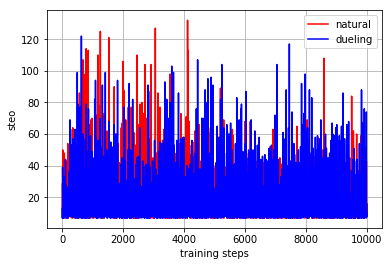

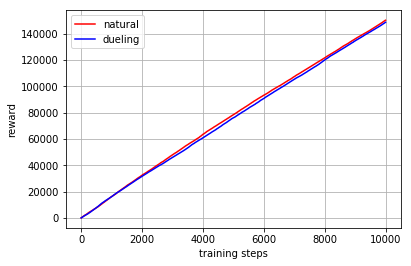

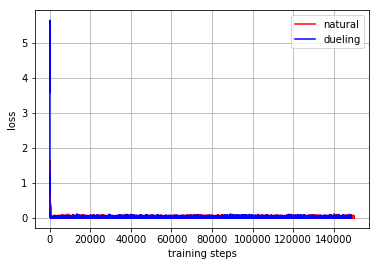

In [8]:
plt.figure(1)
plt.plot(np.array(step_dqn), c='r', label='natural')
plt.plot(np.array(step_dueling), c='b', label='dueling')
plt.legend(loc='best')
plt.ylabel('steo')
plt.xlabel('training steps')
plt.grid()

plt.figure(2)
plt.plot(np.array(reward_dqn), c='r', label='natural')
plt.plot(np.array(reward_dueling), c='b', label='dueling')
plt.legend(loc='best')
plt.ylabel('reward')
plt.xlabel('training steps')
plt.grid()

plt.figure(3)
plt.plot(np.array(loss_dqn), c='r', label='natural')
plt.plot(np.array(loss_dueling), c='b', label='dueling')
plt.legend(loc='best')
plt.ylabel('loss')
plt.xlabel('training steps')
plt.grid()

plt.show()

In [12]:
print("testing...")
reward_all = 0
for i in range(10):
    state = env.reset()
    env.render()
    for step in range(MAX_STEP):
        action = DuelingDQN.greedy_action(state)
        next_state , reward , done , _ = env.step(action)
        reward_all += reward
        if done:
            print(" step: %d "%(step)  )
            break
        state = next_state

print("episode: %d , reward: %f , per_reward: %f"%( reward_all , reward_all/10)  )

testing...
 step: 9 
 step: 9 
 step: 9 
 step: 9 
 step: 7 
 step: 9 
 step: 8 
 step: 8 
 step: 8 
 step: 8 


TypeError: not enough arguments for format string

#### 